In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import os
import torch
import seaborn as sns
import copy

In [2]:
import sys
sys.path.append('code/BalancingControl')
import tmaze_utils as tu
import inference_utils as iu
import inference as inf

import action_selection as asl
import agent as agt
import perception as prc
import environment as env
import world as wld
import action_selection as asl
import misc

Running on device cpu
torch threads 1


In [3]:
group_name = "exposed"

base_dir = "processed_data"
fname_data = os.path.join(base_dir, f"TMaze_{group_name}_structured_data_context.json")
structured_data = misc.load_file(fname_data, fname_data)

In [4]:
print(len(structured_data["subject"][0]))

7


In [5]:
results_dir = os.path.abspath('results')
inference_folder = os.path.join(results_dir, "inference")
print(inference_folder)

/home/sarah/src/TMaze/results/inference


In [6]:
pars = {}
# three states
ns = 3
# three rewards
nr = 3
# two actions
na = 2
# two contexts (corresponding to training and test)
nc = 2
# each session has two time steps: before and after the choice
T = 2

generative_model_states = np.zeros((ns, ns, na))
# state 0 is middle starting point
prior_states = np.array([1., 0., 0.])
# state 1 is right arm
# state 2 is left arm
# action 0 goes to right arm (state 1)
# action 1 goes to left arm (state 2)
# from the arms actions dont matter but for completeness they lead back to the middle
generative_model_states[...,0] = [[0., 1., 1.],
                                  [1., 0., 0.],
                                  [0., 0., 0.]]
generative_model_states[...,1] = [[0., 1., 1.],
                                  [0., 0., 0.],
                                  [1., 0., 0.]]

# reward 0 is bad outcome
# reward 1 is nothing (middle starting point)
# reward 2 is good outcome
prior_rewards = np.array([0.01, 0.14, 0.85])

# environment rules
# right arm gives reward during training, left arm gives nothing, and switches for the test
# we set 200 trials as the maximum possible (however training stops after criterion is reached)
training_trials = 50
# after training comes test
test_trials = 5

total_trials = (training_trials+test_trials)*2
# set outcome rules
generative_process_rewards = np.zeros((total_trials,nr,ns))
# state 0 gives non-reward
# state 1 gives bad outcome during training
# state 2 gives reward during training
generative_process_rewards[:training_trials] = np.array([[0., 1., 0.],
                                                         [1., 0., 0.],
                                                         [0., 0., 1.]])[None,...]
# state 1 gives reward turing test
# state 2 gives bad outcome during test
generative_process_rewards[training_trials:training_trials+test_trials] = np.array([[0., 0., 1.],
                                                         [1., 0., 0.],
                                                         [0., 1., 0.]])[None,...]

generative_process_rewards[training_trials+test_trials:2*training_trials+test_trials] = np.array([[0., 1., 0.],
                                                         [1., 0., 0.],
                                                         [0., 0., 1.]])[None,...]
# state 1 gives reward turing test
# state 2 gives bad outcome during test
generative_process_rewards[2*training_trials+test_trials:2*training_trials+2*test_trials] = np.array([[0., 0., 1.],
                                                         [1., 0., 0.],
                                                         [0., 1., 0.]])[None,...]

# lastly, set up dummy observation model: states are fully observable
generative_model_observations = np.eye(ns)

In [7]:
pars["nm"] = ns
pars["nh"] = ns
pars["nr"] = nr
pars["na"] = na
pars["nc"] = nc
pars["trials"] = total_trials
pars["T"] = T

pars["generative_model_states"] = generative_model_states
pars["generative_model_observations"] = generative_model_observations

In [8]:
env_pars = copy.deepcopy(pars)
env_pars["generative_process_rewards"] = generative_process_rewards

In [9]:
# agent inits

# init reward counts
reward_counts = np.ones((nr,ns,nc))#

# context transition matrix with self transition context stability bias.
self_transition_bias = 0.45
context_transition_matrix = np.array([[0.5+self_transition_bias, 0.5-self_transition_bias],
                                      [0.5-self_transition_bias, 0.5+self_transition_bias]])

# start in one context
prior_context = np.array([1., 0.])

# there are only two policies, one with action 0 and one with action 1
policies = np.array([[0], [1]])
npi = 2

In [10]:
pars["npi"] = npi
pars["transition_matrix_context"] = context_transition_matrix

pars["prior_states"] = prior_states
pars["prior_rewards"] = prior_rewards
pars["prior_context"] = prior_context

pars["all_policies"] = policies

pars["dirichlet_rew_params"] = reward_counts

In [11]:
# extra agent parameters

pars["learn_habit"] = True
pars["learn_rew"] = True
pars["infer_context"] = True
pars["store_internal_variables"] = True
pars["learn_context_obs"] = True

# and things we are not doing:
pars["mask"] = None
pars["hidden_state_mapping"] = False
pars["forgetting_rate_pol"] = 0.
pars["forgetting_rate_rew"] = 0.
pars["infer_alpha_0"] = False
pars["infer_decision_temp"] = False
pars["infer_policy_rate"] = False
pars["infer_reward_rate"] = False
pars["dirichlet_context_obs_params"] = np.ones((nc, nc))

In [12]:
# set parameters and their names

infer_policy_rate = False
infer_reward_rate = False
# the following switches out whether the agent initializes itself with h or alpha_0. Shouldnt matter but was introduced in case inference is more stable for one over the other.
use_h = False
pars["use_h"] = use_h

prefix = "BCC_context_obs_"

model_name = "Bayesian prior-based contextual control model"

if infer_policy_rate and infer_reward_rate:
    n_pars = 4
    h_str = "4param"
    param_names = ["dec temp", "habitual tendency", "policy rate", "reward rate"]
elif infer_policy_rate:
    n_pars = 3
    h_str = "3param_pol"
    param_names = ["dec temp", "habitual tendency", "policy rate"]
elif infer_reward_rate:
    n_pars = 3
    h_str = "3param_rew"
    param_names = ["dec temp", "habitual tendency", "reward rate"]
else:
    n_pars = 2
    h_str = "2param"
    param_names = ["dec temp", "habitual tendency"]

# choose max decision temperature for numerical stability
max_dt = 5

# prepare for saving results
# make base filename and folder string
agent_type = prefix+h_str
fname_base = prefix+h_str+"_"+group_name+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

BCC_context_obs_2param_exposed_inference_


In [13]:
# number of agent subjects to simulate and recover:
n_subjects = len(structured_data["subject"][0])

In [14]:
agent_inference_params = copy.deepcopy(pars)
agent_inference_params["forgetting_rate_pol"] = 0.
agent_inference_params["forgetting_rate_rew"] = 0.
agent_inference_params["infer_alpha_0"] = True
agent_inference_params["infer_decision_temp"] = True
agent_inference_params["infer_policy_rate"] = False
agent_inference_params["infer_reward_rate"] = False
agent_inference_params["mask"] = structured_data["valid"]
agent_inference_params["store_internal_variables"] = False

agent_inference_params["alpha_0"] = 1.
agent_inference_params["dec_temp"] = 1.

In [15]:
print(structured_data["valid"].shape)

torch.Size([110, 7])


In [16]:
# how many inference steps
num_steps = 400

In [17]:
run_inference = True

/home/sarah/src/TMaze/code/BalancingControl/perception.py:635: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1699116133598/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  self.big_trans_matrix = ar.stack([ar.stack([generative_model_states[:,:,policies[pi,t]] for pi in range(self.npi)]) for t in range(self.T-1)]).T.to(device)


2
analyzing 7 data sets
this is inference using <class 'inference.GeneralGroupInference'>
taking steps 1 to 50 out of total 400


  0%|          | 0/50 [00:00<?, ?it/s]

Mean ELBO 600.94: 100%|██████████| 50/50 [00:46<00:00,  1.09it/s]


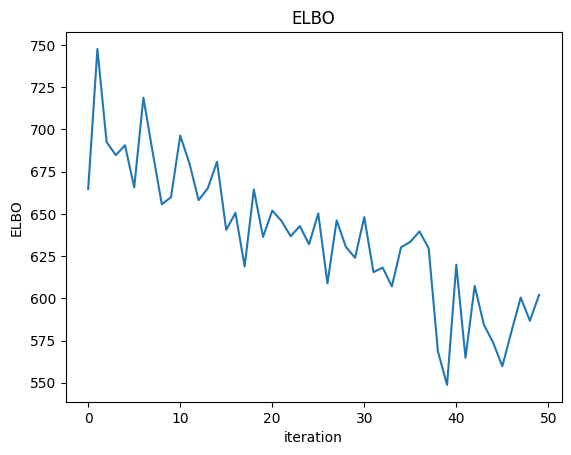

      dec temp  habitual tendency  subject
0     7.205276           7.444429        0
1     2.171888           2.632690        1
2     2.715598           2.229335        2
3     3.235453           4.408875        3
4     4.978580           3.713351        4
...        ...                ...      ...
3495  1.442251           3.629728        2
3496  4.556110           2.810272        3
3497  3.544924           4.974886        4
3498  9.436766           3.781160        5
3499  9.104347           4.207155        6

[3500 rows x 3 columns]


<Figure size 640x480 with 0 Axes>

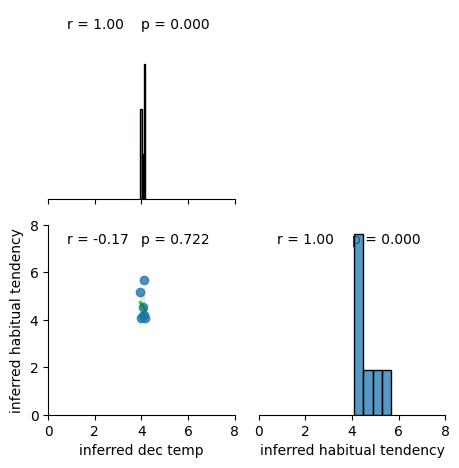

taking steps 51 to 100 out of total 400


Mean ELBO 526.17: 100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


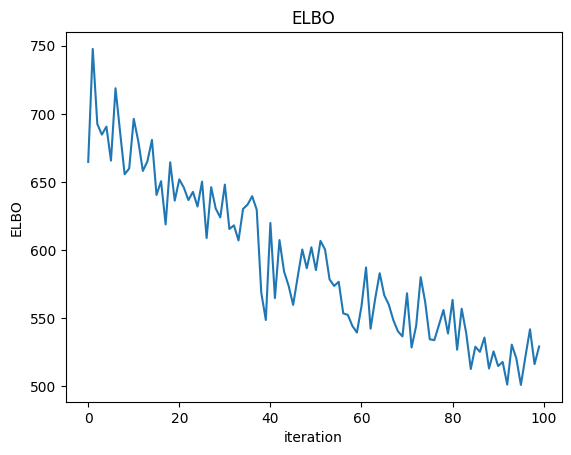

      dec temp  habitual tendency  subject
0     3.261039           3.879602        0
1     0.854972           4.381672        1
2     2.848236           3.188028        2
3     1.680164           5.562963        3
4     4.835169           6.450440        4
...        ...                ...      ...
3495  3.297940           2.139430        2
3496  3.533733           5.430761        3
3497  1.830502           3.270341        4
3498  2.247256           3.051562        5
3499  2.652763           8.235523        6

[3500 rows x 3 columns]


<Figure size 640x480 with 0 Axes>

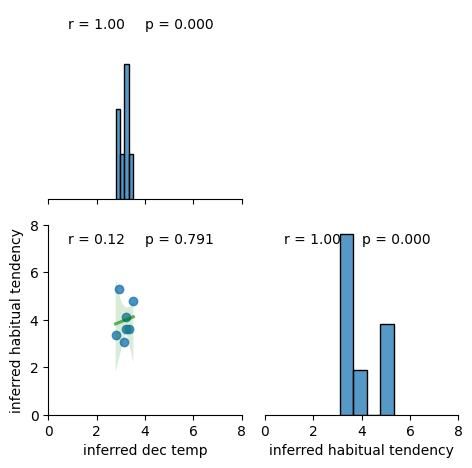

taking steps 101 to 150 out of total 400


Mean ELBO 452.40: 100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


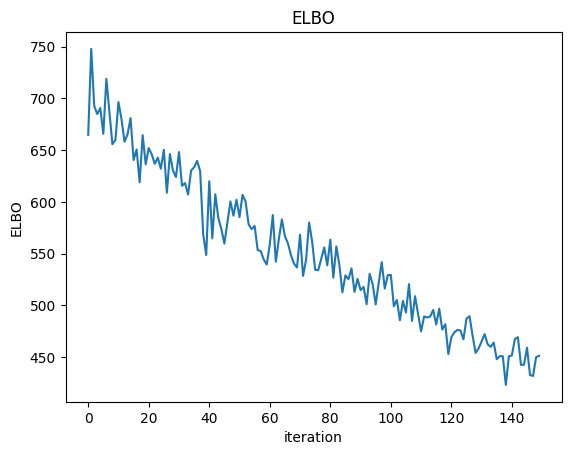

      dec temp  habitual tendency  subject
0     2.454220           4.819085        0
1     1.617350           3.121789        1
2     1.500300           2.824169        2
3     2.690039           4.509142        3
4     4.608063           2.860588        4
...        ...                ...      ...
3495  1.367283           3.991595        2
3496  2.126484           5.662711        3
3497  4.167954           4.249663        4
3498  4.322323           8.321542        5
3499  0.411570           3.329687        6

[3500 rows x 3 columns]


<Figure size 640x480 with 0 Axes>

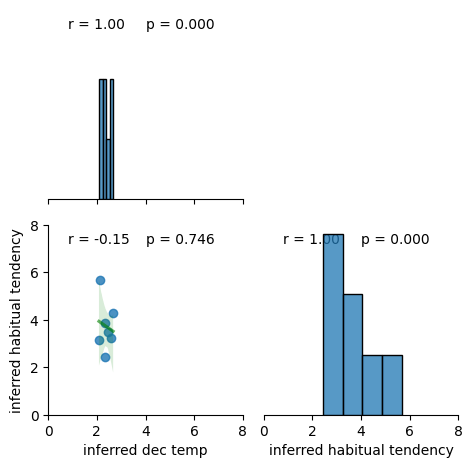

taking steps 151 to 200 out of total 400


Mean ELBO 387.72: 100%|██████████| 50/50 [00:59<00:00,  1.20s/it]


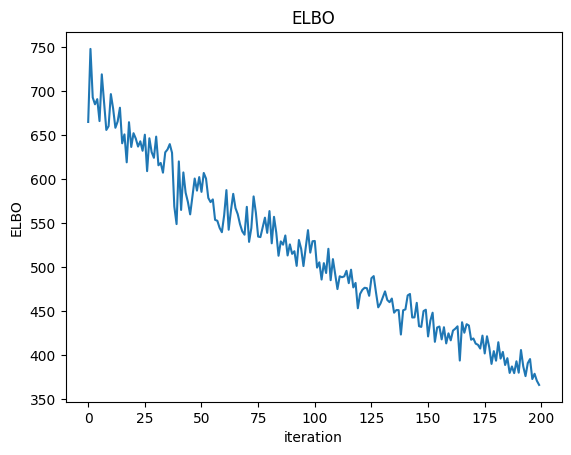

      dec temp  habitual tendency  subject
0     1.239905           2.687774        0
1     1.150858           3.106744        1
2     0.886580           2.512923        2
3     0.994476           4.385150        3
4     1.580130           1.387774        4
...        ...                ...      ...
3495  1.304493           3.769863        2
3496  1.845184           2.589833        3
3497  1.899921           0.769743        4
3498  1.210945           3.022021        5
3499  0.149227           2.147788        6

[3500 rows x 3 columns]


<Figure size 640x480 with 0 Axes>

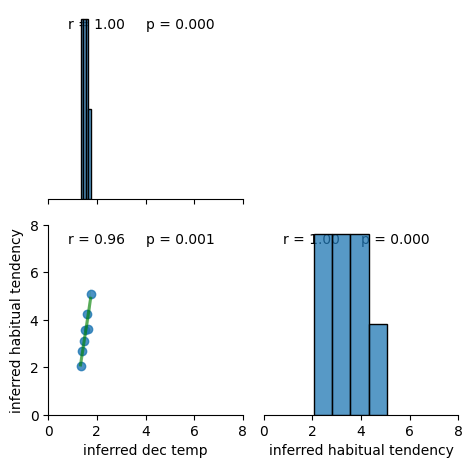

taking steps 201 to 250 out of total 400


Mean ELBO 342.12: 100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


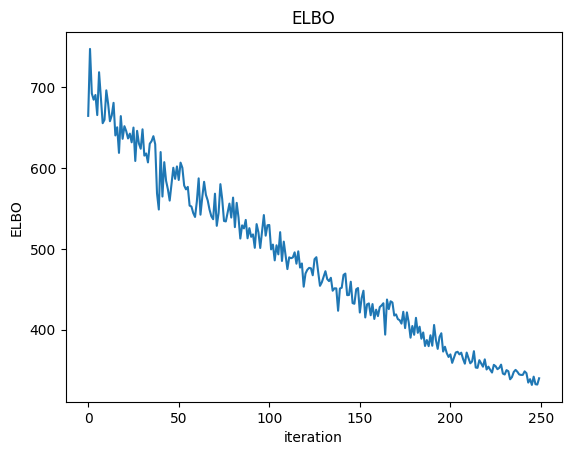

      dec temp  habitual tendency  subject
0     1.251522           4.976616        0
1     1.222878           4.139047        1
2     1.221018           2.586848        2
3     1.754893           2.989235        3
4     0.798389           2.720038        4
...        ...                ...      ...
3495  1.475900           3.322166        2
3496  1.792361           5.280529        3
3497  0.645352           2.174086        4
3498  0.648589           1.631262        5
3499  0.692673           3.116014        6

[3500 rows x 3 columns]


<Figure size 640x480 with 0 Axes>

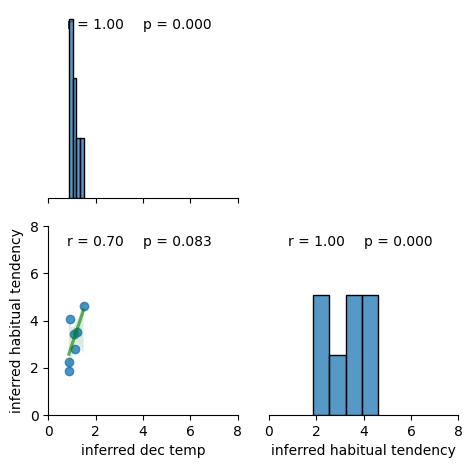

taking steps 251 to 300 out of total 400


Mean ELBO 318.34: 100%|██████████| 50/50 [00:56<00:00,  1.12s/it]


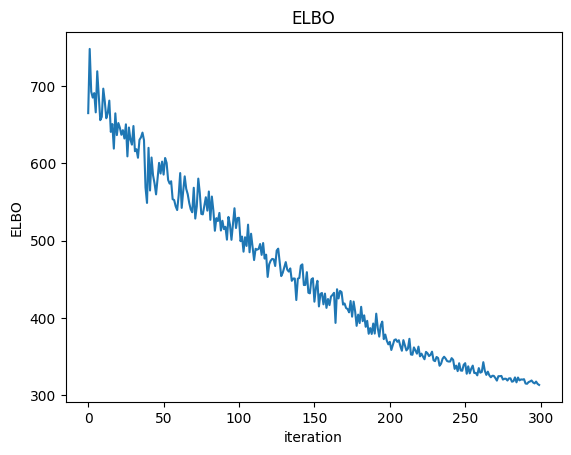

      dec temp  habitual tendency  subject
0     1.328128           4.013584        0
1     0.390172           3.032427        1
2     0.840844           2.987455        2
3     1.577963           1.400351        3
4     1.484173           1.552172        4
...        ...                ...      ...
3495  1.119125           2.091857        2
3496  0.762729           1.556963        3
3497  0.717824           1.727317        4
3498  0.425247           2.436946        5
3499  0.476641           2.433151        6

[3500 rows x 3 columns]


<Figure size 640x480 with 0 Axes>

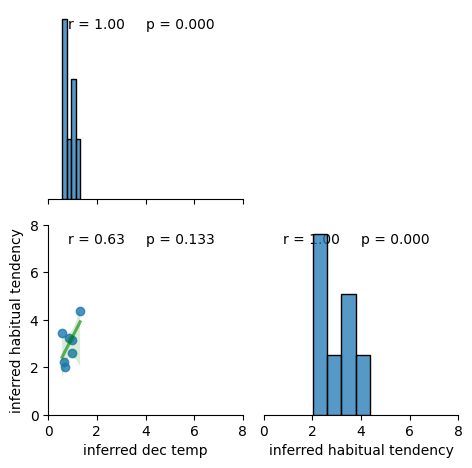

taking steps 301 to 350 out of total 400


Mean ELBO 310.21: 100%|██████████| 50/50 [00:53<00:00,  1.08s/it]


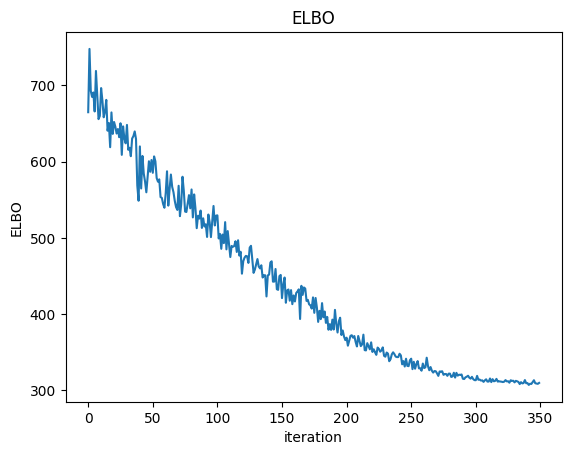

      dec temp  habitual tendency  subject
0     1.427413           3.873703        0
1     1.055777           3.772415        1
2     1.264594           3.212122        2
3     1.099250           2.424584        3
4     0.338923           2.131449        4
...        ...                ...      ...
3495  0.730590           2.322712        2
3496  1.227660           2.310870        3
3497  0.943659           0.912585        4
3498  0.539699           1.889171        5
3499  0.560389           2.496072        6

[3500 rows x 3 columns]


<Figure size 640x480 with 0 Axes>

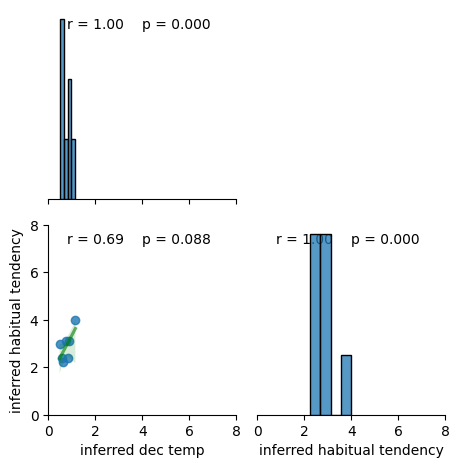

taking steps 351 to 400 out of total 400


Mean ELBO 305.89: 100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


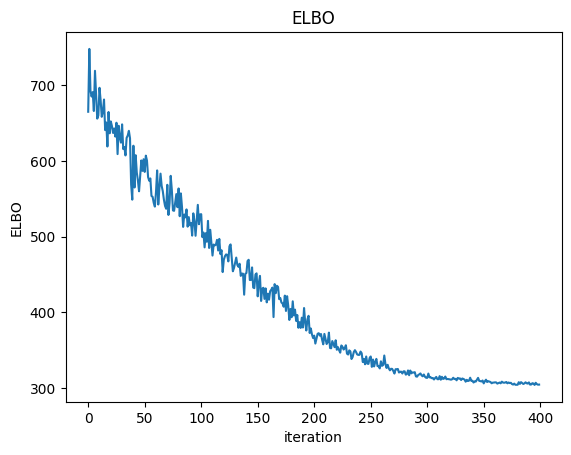

      dec temp  habitual tendency  subject
0     0.862096           3.007037        0
1     0.631185           3.008871        1
2     0.906282           2.402534        2
3     0.981234           2.979715        3
4     0.487618           2.394245        4
...        ...                ...      ...
3495  0.794404           2.435301        2
3496  0.696879           3.443928        3
3497  0.447742           1.906762        4
3498  0.491084           3.310282        5
3499  0.465113           2.272629        6

[3500 rows x 3 columns]


<Figure size 640x480 with 0 Axes>

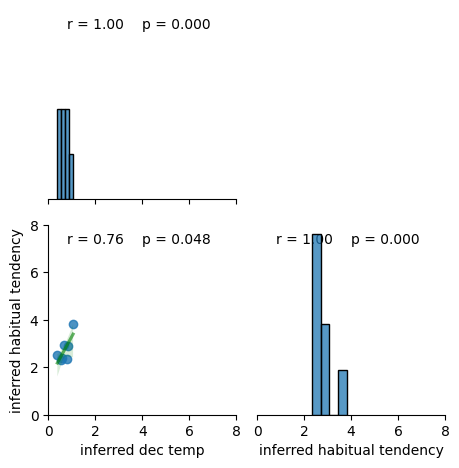

In [18]:
if run_inference:

    # remove old inference?
    remove_old = True

    # set up agent
    bayes_agent = tu.set_up_Bayesian_inference_agent(n_subjects, agent_inference_params, base_dir, remove_old=remove_old)

    print('analyzing '+str(n_subjects)+' data sets')

    # set up inference
    inferrer = inf.GeneralGroupInference(bayes_agent, structured_data)

    num_particles = 15


    print("this is inference using", type(inferrer))
    
    size_chunk = 50
    total_num_iter_so_far = 0

    for i in range(total_num_iter_so_far, num_steps, size_chunk):
        print('taking steps '+str(i+1)+' to '+str(i+size_chunk)+' out of total '+str(num_steps))

        fname_str = fname_base + str(total_num_iter_so_far+size_chunk)+'_'+str(n_subjects)+'agents'

        iu.infer(inferrer, size_chunk, fname_str, num_particles, base_dir)
        total_num_iter_so_far += size_chunk

        inferrer.save_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

        inferrer.save_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

        # sample from posterior only at last time step and save results. Could be done at every step, if earlier posteriors are of interest, one can load the inferrer save and sample from that.
        mean_df, sample_df, locs_df = iu.sample_posterior(inferrer, param_names, fname_str, base_dir) 
        param_plot_ranges = [[0,8], [0,8]]

        plt.figure()
        vars_of_interest = ["inferred "+name for name in param_names]
        f = sns.pairplot(data=mean_df, kind='reg', diag_kind="hist", corner=True,# hue="subject",
                            plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                            grid_kws={"layout_pad": 1.5},
                            x_vars=vars_of_interest, y_vars=vars_of_interest)
        f.map(misc.annot_corrfunc)
        for p, p_range in enumerate(param_plot_ranges):
            f.axes[n_pars-1,p].set_xlim(p_range)
            f.axes[p,0].set_ylim(p_range)
        plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
        plt.show()


In [19]:
print(sample_df["dec temp"].mean())

0.7026947


In [20]:
print(sample_df["habitual tendency"].mean())

2.747984
